ISLA: Tenerife, WINDOW = 9
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @138845045509136
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @138844758593040
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @138844758593232
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @138844748799504
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @138844748797904
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @138844748795856
Epoch [500/20000], Train Loss: 0.0191, Val Loss: 0.0195

Epoch [1000/20000], Train Loss: 0.0185

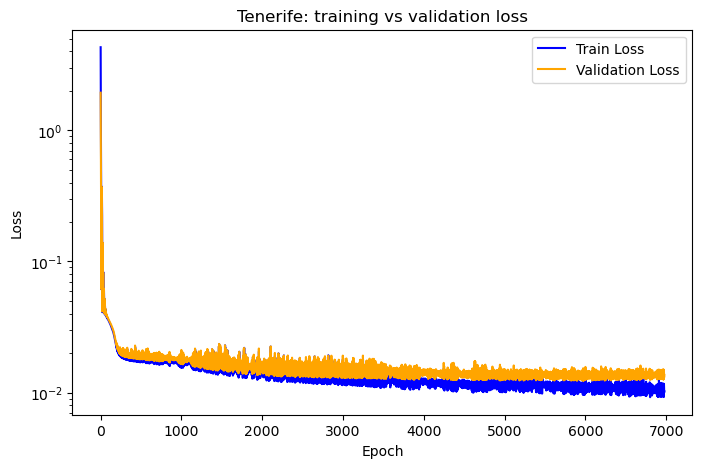

Evaluation Metrics:
R2: 0.7677666268725285
MAE: 104.2162
MSE: 40105.6681
RMSE: 200.2640
R2: 0.7678
MAPE: 0.0122
sMAPE: 0.0121




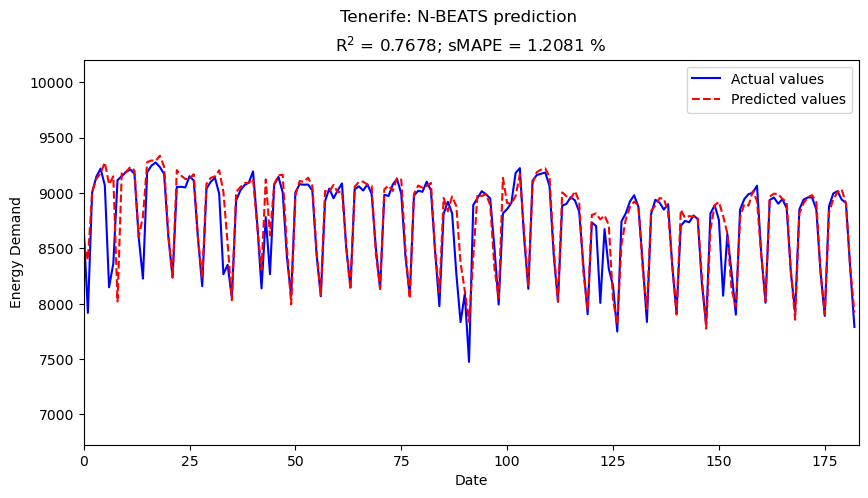

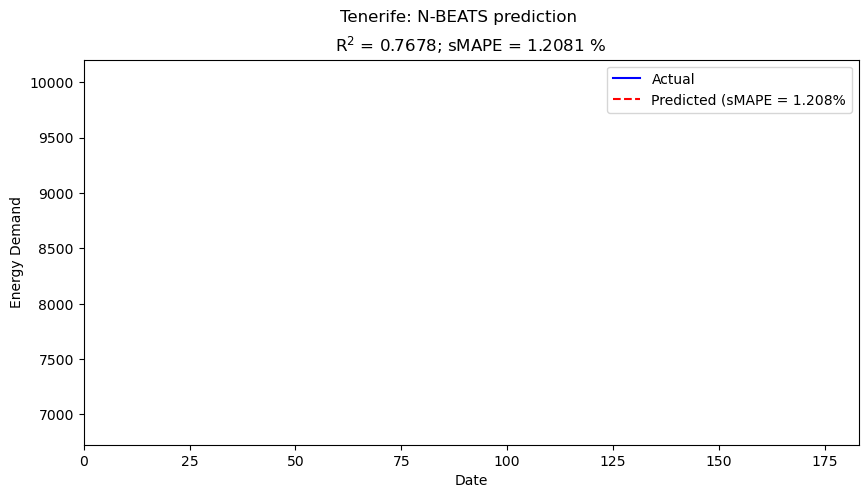

ISLA: El Hierro, WINDOW = 19
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=19, forecast_length=1, share_thetas=False) at @138844550420944
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=19, forecast_length=1, share_thetas=False) at @138844550094544
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=19, forecast_length=1, share_thetas=False) at @138844551665616
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=19, forecast_length=1, share_thetas=False) at @138844549649744
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=19, forecast_length=1, share_thetas=False) at @138844471540176
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=19, forecast_length=1, share_thetas=False) at @138844471296720
Epoch [500/20000], Train Loss: 0.0276, Val Loss: 0.0234

Epoch [1000/20000], Train Loss

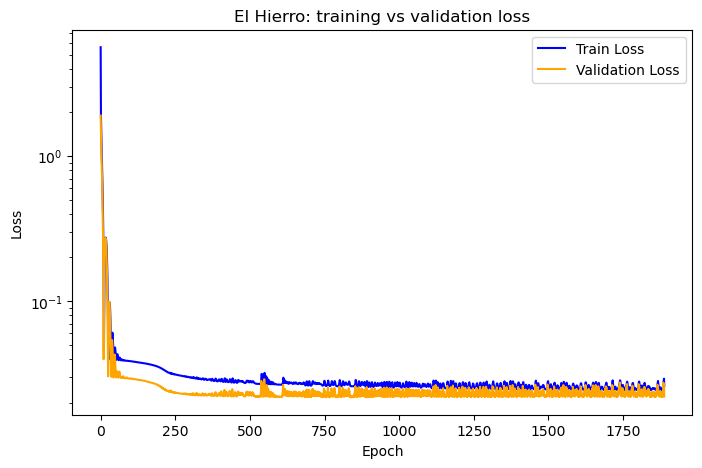

Evaluation Metrics:
R2: 0.25418092829910954
MAE: 2.7820
MSE: 14.5502
RMSE: 3.8145
R2: 0.2542
MAPE: 0.0212
sMAPE: 0.0211




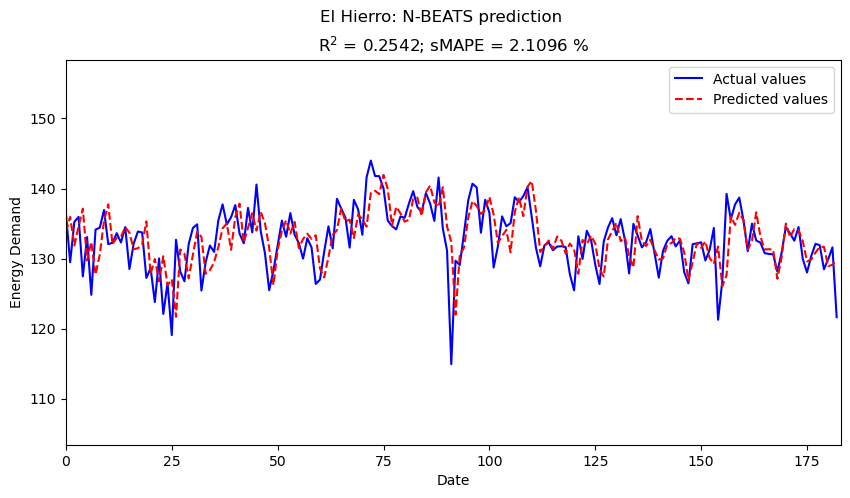

/home/nikitakhvatkin/anaconda3/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


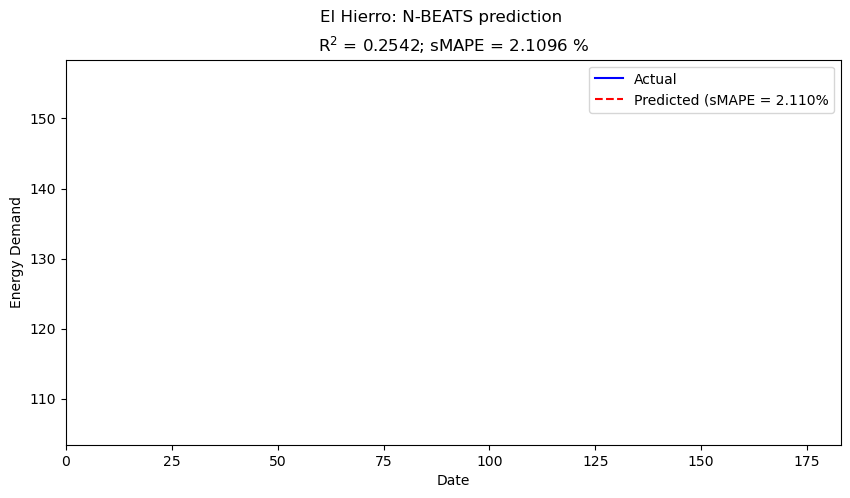

In [1]:
# Imports
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

from src.utils import metrics
from src.utils import data_loader as d
from src.utils import models
from src.utils import sliding_window as s

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Load Data
islas_dfs = d.local_data_loader(verbose=False)

# islas = ['Tenerife', 'Gran Canaria', 'Lanzarote', 'Fuerteventura', 'La Palma', 'La Gomera', 'El Hierro']
# windows = [9, 11, 11, 8, 7, 6, 19]

islas = ['Tenerife', 'El Hierro']
windows = [9, 19]

for isla, window in zip(islas, windows):

        print(f'ISLA: {isla}, WINDOW = {window}')

        # Extract demand value
        demand = islas_dfs[isla]['OBS_VALUE'].values.reshape(-1,1) # data['energy'].values.reshape(-1, 1)

        # Data scaling
        # scaler = MaxAbsScaler()
        # demand_scaled = scaler.fit_transform(demand)
        # demand = np.log1p(demand / demand.max())

        # Training and validation
        train_size = 1460  # First 4 years for training/validation
        val_size = int(0.2 * train_size)  # 20% of training data for validation
        window_size = window 

        # Split into training, validation, and test sets
        train_data = demand[:train_size - val_size]
        val_data = demand[train_size - val_size:train_size]
        test_data = demand[train_size - window_size:]

        # Sliding window sequences for training and validation
        train_sequences, train_targets = s.create_sequences(train_data, window_size)
        val_sequences, val_targets = s.create_sequences(val_data, window_size)

        # Convert to PyTorch tensors
        train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
        train_targets = torch.tensor(train_targets, dtype=torch.float32)
        val_sequences = torch.tensor(val_sequences, dtype=torch.float32)
        val_targets = torch.tensor(val_targets, dtype=torch.float32)
        # Model training and validation
        from nbeats_pytorch.model import NBeatsNet 

        model = NBeatsNet(
            stack_types=("generic", "generic"),
            forecast_length=1,
            backcast_length=window_size,
            hidden_layer_units=128
        )

        def log_mae(pred, target):
            return torch.mean(torch.abs(torch.log1p(pred) - torch.log1p(target)))

        criterion = log_mae # nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        train_losses, val_losses = [], []
        best_val_loss = float('inf')
        stopping_counter = 0
        early_stopping = True

        num_epochs = 20_000 
        early_stopping_patience = 1_000

        for epoch in range(num_epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            _, output = model(train_sequences)
            train_loss = criterion(output, train_targets)
            train_loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            with torch.no_grad():
                _, val_output = model(val_sequences)
                val_loss = criterion(val_output, val_targets)

            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                stopping_counter = 0
            else:
                stopping_counter += 1

            if early_stopping and stopping_counter >= early_stopping_patience:
                # print("Early stopping triggered!")
                break

            if (epoch + 1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}\n')

        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.title(f'{isla}: training vs validation loss')
        plt.legend()
        # plt.savefig(f'../outputs/figures/nbeats_training_{isla}.png')
        plt.show()

        # Prediction
        test_sequences, test_targets = s.create_sequences(test_data, window_size)
        test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
        test_targets = torch.tensor(test_targets, dtype=torch.float32)

        # Initialize lists for storing predictions
        online_predictions = []
        actual_values = []

        # Define online optimizer and loss function
        online_optimizer = optim.Adam(model.parameters(), lr=1e-6)
        criterion = nn.MSELoss()

        for i in range(len(test_sequences)):
            x = test_sequences[i].unsqueeze(0)

            # Model inference
            model.eval()
            with torch.no_grad():
                pred = model(x)[1]  # Extract the forecast output
            online_predictions.append(pred.item())
            actual_values.append(test_targets[i].item())

            # Online learning step
            model.train()
            online_optimizer.zero_grad()
            pred_online = model(x)[1]  # Extract forecast again for training
            loss_online = criterion(pred_online, test_targets[i].unsqueeze(0))
            loss_online.backward()
            online_optimizer.step()

        # online_predictions_inv = scaler.inverse_transform(np.array(online_predictions).reshape(-1, 1)).flatten()
        # actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1)).flatten()
        # online_predictions = np.expm1(np.array(online_predictions)) * demand.max()
        # actual_values = np.expm1(np.array(actual_values)) * demand.max()

        metrics_result = metrics.all_metrics(actual_values, online_predictions)
        print("Evaluation Metrics:")
        print(f"R2: {metrics_result['R2']}")
        for metric, value in metrics_result.items():
            print(f"{metric}: {value:.4f}")
        print('\n')

        # Animation
        test_dates = islas_dfs[isla]['TIME_PERIOD_CODE'].values.reshape(-1,1)

        fig, ax = plt.subplots(figsize=(10, 5))
        plt.suptitle(f'{isla}: N-BEATS prediction')
        ax.set_xlim(0, len(actual_values))
        ax.set_ylim(min(actual_values) * 0.9, max(actual_values) * 1.1)
        ax.set_xlabel("Date")
        ax.set_ylabel("Energy Demand")
        ax.set_title(f"R$^2$ = {metrics_result['R2']:.4f}; sMAPE = {100*metrics_result['sMAPE']:.4f} %")

        ax.plot(actual_values, label = 'Actual values', color = 'blue')
        ax.plot(online_predictions, '--r' ,label = 'Predicted values')

        ax.legend()
        # plt.savefig(f'../outputs/pred/per_island/nbeats_{isla}.png')
        plt.show()
        print('\n')
        
        from datetime import datetime

        fig, ax = plt.subplots(figsize=(10, 5))
        plt.suptitle(f'{isla}: N-BEATS prediction')
        ax.set_xlim(0, len(actual_values))
        ax.set_ylim(min(actual_values) * 0.9, max(actual_values) * 1.1)
        ax.set_xlabel("Date")
        ax.set_ylabel("Energy Demand")
        ax.set_title(f"R$^2$ = {metrics_result['R2']:.4f}; sMAPE = {100*metrics_result['sMAPE']:.4f} %")

        actual_line, = ax.plot([], [], color='blue', label="Actual")
        predicted_line, = ax.plot([], [], color='red', linestyle="dashed", 
                                  label=f"Predicted (sMAPE = {100*metrics_result['sMAPE']:.3f}%")
        ax.legend()

        # Update function
        def update(frame):
            actual_line.set_data(range(frame), actual_values[:frame])
            predicted_line.set_data(range(frame), online_predictions[:frame])

        # Create animation
        ani = animation.FuncAnimation(fig, update, frames=len(actual_values), interval=50)

        # Save video
        # ani.save(f"../outputs/pred/per_island/nbeats_predictions_{isla}.gif", writer="ffmpeg", fps=75)

        plt.show()